<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C1/C1.html"><img src="../data/C1_nav.png" width="100"  style="float:right;" alt="C1"></a>
<h1>Symbolic Format: MusicXML</h1>        
</div>

<br />

<p>
Following Section 1.2.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we look in this notebook at a symbolic music representation called MusicXML.
</p> 

## Score Representations

Within the class of symbolic music representations, we want to distinguish one subclass we refer to as **score representations**. A representation from this subclass is defined to yield explicit information about musical symbols such as the staff system, clefs, time signatures, notes, rests, accidentals, and dynamics.  In this sense, score representations are, compared with [MIDI representations](../C1/C1S2_MIDI.html), much closer to what is actually shown in sheet music.  For example, in a score representation, the notes $\mathrm{D}^\sharp4$ and $\mathrm{E}^\flat4$ would be distinguishable. Furthermore, musical (rather than physical) onset times are specified. However, a score representation may not contain a description of the final layout and the particular shape of the musical symbols. The process of generating or rendering visually pleasing sheet music representations from score representations is an art in itself. In former days, the art of drawing high-quality music notation for mechanical reproduction was called **music engraving**. Nowadays, computer software 
or **scorewriters** have been designed for the purpose of writing, editing, and printing music, though only a few produce results comparable to high-quality traditional engraving. The following figure illustrates this by showing different sheet music representations corresponding to the same score representation of the beginning of Prelude BWV 846 ($\mathrm{C}$ major) by Johann Sebastian Bach. From top left to bottom right, a computer-generated, a handwritten, and two traditionally engraved representations are shown. 

<img src="../data/C1/FMP_C1_F14.png" width="400px" align="middle" alt="C1">

## MusicXML

There are various symbolic score formats. In the following, as an example, we discuss some aspects of [**MusicXML**](https://www.musicxml.com/), which has been developed to serve as a universal format for storing music files and sharing them between different music notation applications. Following the general XML (Extensible Markup Language) paradigm, MusicXML is a textual data format that defines a set of rules for encoding documents in a way that is both human and machine readable. The following figure shows how a note $\mathrm{E}^\flat{4}$ is encoded. 

<img src="../data/C1/FMP_C1_F15.png" width="300px" align="middle" alt="C1">

In the MusicXML encoding of the half note $\mathrm{E}^\flat{4}$, the tags `<note>` and `</note>` mark the beginning and the end of a MusicXML note element. The pitch element, delimited by the tags `<pitch>` and `</pitch>`, consists of a pitch class element $\mathrm{E}$ (denoting the letter name of the pitch), the alter element $-1$ (changing $\mathrm{E}$ to $\mathrm{E}^\flat$ ), and the octave element $4$ (fixing the octave). Thus, the resulting note is an $\mathrm{E}^\flat{4}$. The element `<duration>2</duration>` encodes the duration of the note measured in quarter notes. Finally, the  element `<type>half</type>` tells us how this note is actually depicted in the rendered sheet music.

The following code cell reads in a simple MusicXML file containing only a single note.
Then, we search for the start and end indices of the first note element and print the corresponding XML string.

In [1]:
import sys
import os

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import pandas as pd
import IPython.display as ipd
import music21 as m21

sys.path.append('..')
import libfmp.c1

fn = os.path.join('..', 'data', 'C1', 'FMP_C1_F15_Eflat.xml')

with open(fn, 'r') as stream:
    xml_str = stream.read()

start = xml_str.find('<note')
end = xml_str[start:].find('</note>') + start + len('</note>')
print(xml_str[start:end])

<note default-x="104.28" default-y="-40.00">
        <pitch>
          <step>E</step>
          <alter>-1</alter>
          <octave>4</octave>
          </pitch>
        <duration>2</duration>
        <voice>1</voice>
        <type>half</type>
        <stem>up</stem>
        </note>


## Processing MusicXML Files Using `music21`

The Python package [`music21`](https://web.mit.edu/music21/) is a toolkit for computer-aided musicology, which allows users to study large datasets of music, to generate musical examples, to teach fundamentals of music theory, to edit musical notation, study music and the brain, and to compose music. In particular, `music21` can be used for reading MusicXML files. For example, one may parse a MusicXML file into a `music21` object and display it graphically using the following code:

```
s = m21.converter.parse(fn)
s.show('musicXML')
```
This may result in the following rendering:

<img src="../data/C1/FMP_C1_F15_Eflat_music21_export.png" width="200px" align="left" alt="C1">

<br clear="all" />

To make this work, you may need additional software and system-depending stetting. Some options are explained in more detail in the [FMP notebook on sheet music rendering](../C1/C1S2_SymbolicRendering.html).

In the following, we will use the beginning of Beethoven's Fifth Symphony as a running example. Refer to the [FMP notebook on sheet music representations](../C1/C1S1_SheetMusic.html) for several renditions of the sheet music.

In [2]:
fn = os.path.join('..', 'data', 'C1', 'FMP_C1_F01_Beethoven_FateMotive_Sibelius.xml')

## Processing and Visualization with `music21`

We use the Python package [`music21`](https://web.mit.edu/music21/) for reading MusicXML files. The following code cell parses the MusicXML file, stores the data into a standard Python list and displays the first note events in a table.

In [3]:
def xml_to_list(xml):
    """Convert a music xml file to a list of note events

    Notebook: C1/C1S2_MusicXML.ipynb

    Args:
        xml (str or music21.stream.Score): Either a path to a music xml file or a music21.stream.Score

    Returns:
        score (list): A list of note events where each note is specified as
            ``[start, duration, pitch, velocity, label]``
    """

    if isinstance(xml, str):
        xml_data = m21.converter.parse(xml)
    elif isinstance(xml, m21.stream.Score):
        xml_data = xml
    else:
        raise RuntimeError('midi must be a path to a midi file or music21.stream.Score')

    score = []

    for part in xml_data.parts:
        instrument = part.getInstrument().instrumentName

        for note in part.flat.notes:

            if note.isChord:
                start = note.offset
                duration = note.quarterLength

                for chord_note in note.pitches:
                    pitch = chord_note.ps
                    volume = note.volume.realized
                    score.append([start, duration, pitch, volume, instrument])

            else:
                start = note.offset
                duration = note.quarterLength
                pitch = note.pitch.ps
                volume = note.volume.realized
                score.append([start, duration, pitch, volume, instrument])

    score = sorted(score, key=lambda x: (x[0], x[2]))
    return score

xml_data = m21.converter.parse(fn)
xml_list = xml_to_list(xml_data)

df = pd.DataFrame(xml_list[:9], columns=['Start', 'End', 'Pitch', 'Velocity', 'Instrument'])
html = df.to_html(index=False, float_format='%.2f', max_rows=8)
ipd.HTML(html)

Start,End,Pitch,Velocity,Instrument
0.50,0.50,43.00,0.71,Piano (2)
0.50,0.50,55.00,1.00,Piano (2)
0.50,0.50,67.00,1.00,Piano (2)
1.00,0.50,43.00,0.71,Piano (2)
...,...,...,...,...
1.00,0.50,67.00,1.00,Piano (2)
1.50,0.50,43.00,0.71,Piano (2)
1.50,0.50,55.00,1.00,Piano (2)
1.50,0.50,67.00,1.00,Piano (2)


Now, we plot the note events in a piano roll representation, where the grayscale color of a rectangle is controlled by the volume of the corresponding note. We now use a visualization function from `libfmp` that has been introduced in the notebook on our [CSV format for symbolic music](../C1/C1S2_CSV.html).

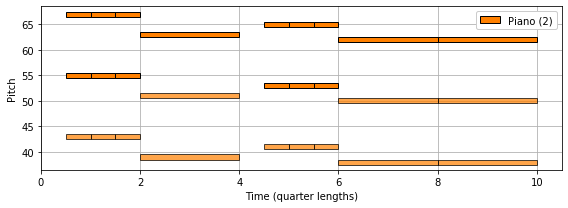

In [4]:
libfmp.c1.visualize_piano_roll(xml_list, figsize=(8, 3), velocity_alpha=True,
                               xlabel='Time (quarter lengths)');

As an alternative, the color of a rectangle can also be controlled by the instrument of the corresponding note. The following code cell illustrates this functionality for the orchestral version of the score.

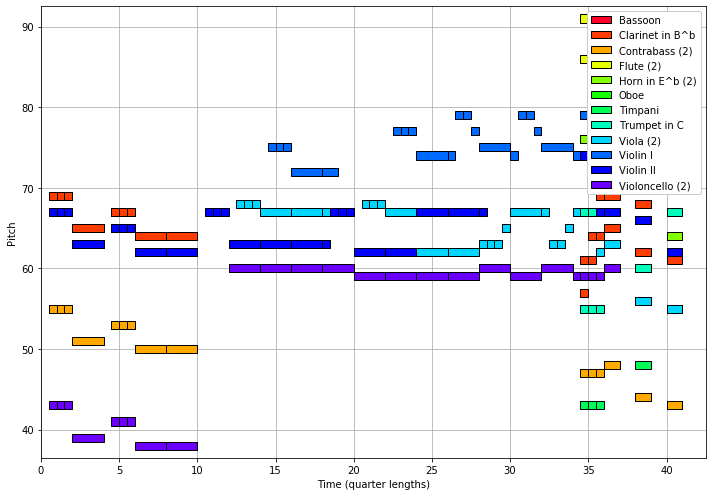

In [5]:
fn = os.path.join('..', 'data', 'C1', 'FMP_C1_F10_Beethoven_Fifth-MM1-21_Sibelius-Orchestra.xml')
xml_data = m21.converter.parse(fn)
xml_list = xml_to_list(xml_data)
libfmp.c1.visualize_piano_roll(xml_list, figsize=(10, 7), velocity_alpha=False,
                               colors='gist_rainbow', xlabel='Time (quarter lengths)');


## Conversion from MusicXML to CSV

We can convert a list of note events into a CSV file with the [`to_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) method of a `pd.DataFrame`, see also the [FMP notebook on MIDI format](../C1/C1S2_MIDI.html) and the [FMP notebook on the CSV format](../C1/C1S2_CSV.html).

In [6]:
fn = os.path.join('..', 'data', 'C1', 'FMP_C1_F10_Beethoven_Fifth-MM1-21_Sibelius-Orchestra.xml')
fn_out = os.path.join('..', 'output', 'C1', 'FMP_C1_F10_Beethoven_Fifth-MM1-21_Sibelius-Orchestra.csv')
xml_data = m21.converter.parse(fn)
xml_list = xml_to_list(xml_data)
df = pd.DataFrame(xml_list, columns=['Start', 'End', 'Pitch', 'Velocity', 'Instrument'])
df.to_csv(fn_out, sep=';', quoting=2, float_format='%.3f')

print('Score as list:')
print(xml_list[0:3])
print('\n')

print('Score as pandas DataFrame')
print(df.loc[0:2,:])
print('\n')

print('Score as CSV')
print(fn_out)
with open(fn_out, 'r', encoding='utf-8') as file:
    csv_str = file.readlines()
print(csv_str[0:4])

Score as list:
[[0.5, 0.5, 43.0, 1.0, 'Violoncello (2)'], [0.5, 0.5, 55.0, 1.0, 'Viola (2)'], [0.5, 0.5, 55.0, 1.0, 'Contrabass (2)']]


Score as pandas DataFrame
   Start  End  Pitch  Velocity       Instrument
0    0.5  0.5   43.0       1.0  Violoncello (2)
1    0.5  0.5   55.0       1.0        Viola (2)
2    0.5  0.5   55.0       1.0   Contrabass (2)


Score as CSV
../output/C1/FMP_C1_F10_Beethoven_Fifth-MM1-21_Sibelius-Orchestra.csv
['"";"Start";"End";"Pitch";"Velocity";"Instrument"\n', '0;"0.500";"0.500";"43.000";"1.000";"Violoncello (2)"\n', '1;"0.500";"0.500";"55.000";"1.000";"Viola (2)"\n', '2;"0.500";"0.500";"55.000";"1.000";"Contrabass (2)"\n']


## Further Notes

The functions to convert an XML file to a list of note events as well as the pianoroll visualization function have been included into `libfmp`. In the following code cell, we call those `libfmp` functions:

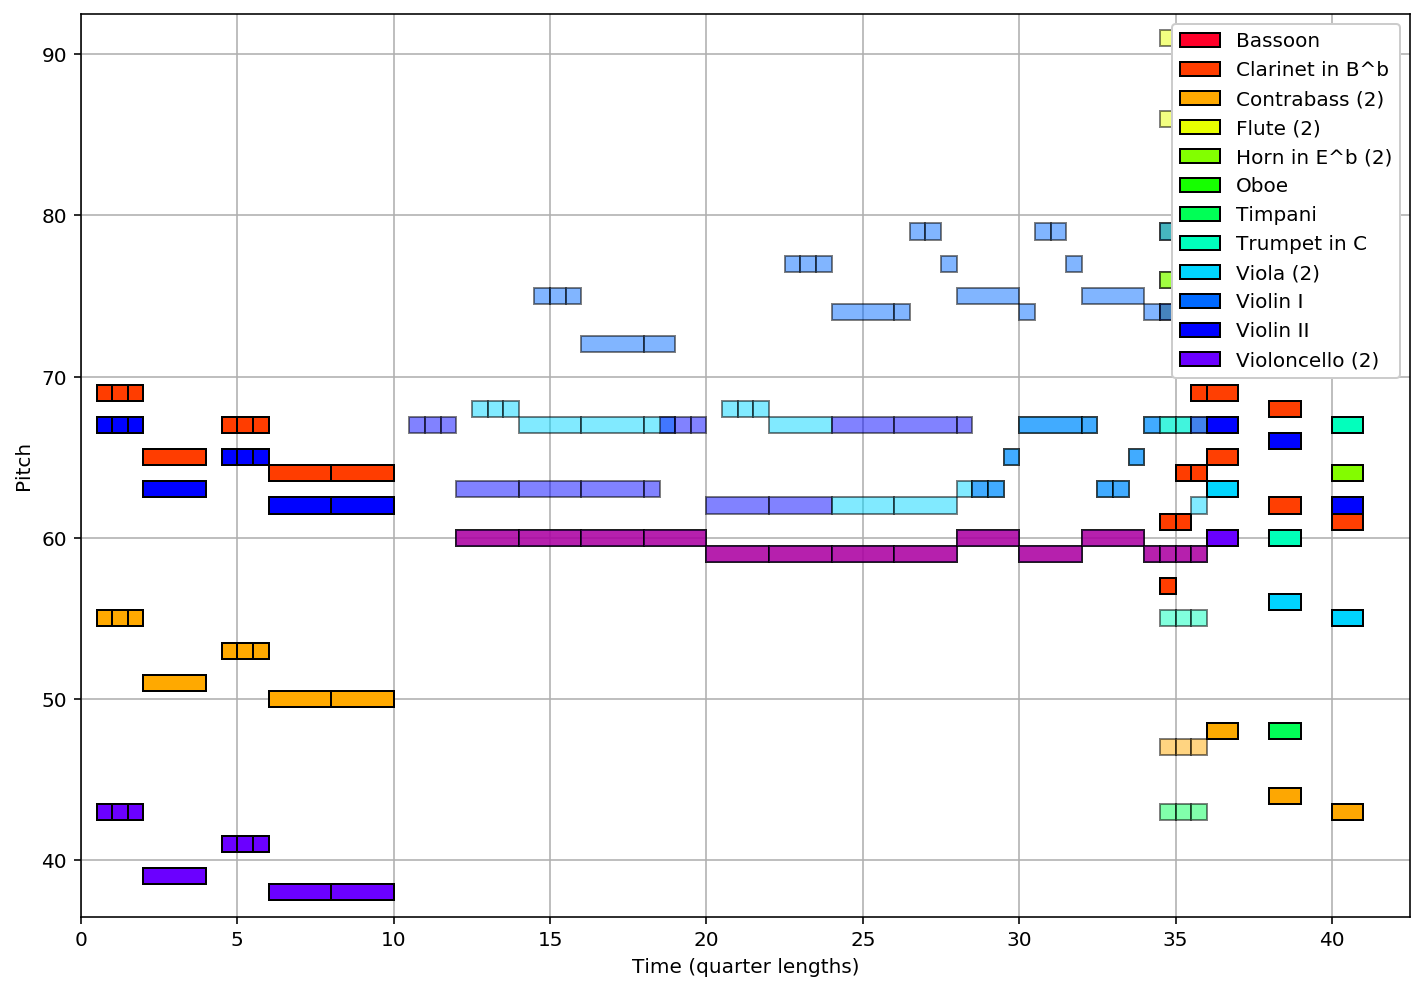

In [7]:
import sys
sys.path.append('..')
import libfmp.c1

fn = os.path.join('..', 'data', 'C1', 'FMP_C1_F13a_Beethoven_FateMotive_Sibelius.xml')
fn_out = os.path.join('..', 'output', 'C1', 'FMP_C1_F13a_Beethoven_FateMotive_Sibelius.csv')

score = libfmp.c1.xml_to_list(fn)
libfmp.c1.visualize_piano_roll(xml_list, figsize=(10, 7), velocity_alpha=True,
                               colors='gist_rainbow', xlabel='Time (quarter lengths)')
libfmp.c1.list_to_csv(score, fn_out)

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a> and <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div>    

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>